In [2]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101, NASNetMobile, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

tf.config.optimizer.set_jit(False)

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError:
        pass

tf.keras.mixed_precision.set_global_policy('mixed_float16')

AUTOTUNE = tf.data.AUTOTUNE

DATA_DIR   = r'C:/Users/maxim/Documents/DLProjectDress/datasets'

BATCH_SIZE = 32
EPOCHS     = 5
LR         = 1e-4
INPUT_SIZE = (224, 224)

# compute global mean & std of the 'year' label
all_dfs = [pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
           for i in range(10)]
df_all  = pd.concat(all_dfs, ignore_index=True)
YEAR_MEAN = df_all['year'].mean()
YEAR_STD  = df_all['year'].std()
print(f'Label mean year = {YEAR_MEAN:.2f}, std = {YEAR_STD:.2f}')


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 SUPER, compute capability 8.9
Label mean year = 1845.86, std = 16.43


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
def preprocess(path, label, training):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, INPUT_SIZE)
    if training:
        img = tf.image.random_flip_left_right(img)
    img = img / 255.0

    # normalize the year label to zero‐mean, unit‐std
    label = (label - YEAR_MEAN) / YEAR_STD
    return img, tf.cast(label, tf.float32)

def make_dataset(df, training):
    df = df.copy()
    #df['file'] = df['file'].str.replace(r'^datasets[\\/]', '', regex=True)

    files  = [os.path.join(DATA_DIR, p) for p in df['file']]
    labels = df['year'].values

    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(files))
    ds = ds.map(lambda x,y: preprocess(x,y,training),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


In [5]:
def build_model(name, base, input_shape=(*INPUT_SIZE, 3), lr=LR):
    x = GlobalAveragePooling2D()(base.output)
    out = Dense(1)(x)   # regression head

    model = Model(base.input, out)
    print(model.summary())
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

In [ ]:
models = ['resnet101','nasnetmobile','inceptionv3']
results = {m: [] for m in models}

for model_name in models:
    if model_name == 'resnet101':
        base = ResNet101(include_top=False, weights='imagenet',
                         input_shape=(*INPUT_SIZE, 3))
    elif model_name == 'nasnetmobile':
        base = NASNetMobile(include_top=False, weights='imagenet',
                            input_shape=(*INPUT_SIZE, 3))
    elif model_name == 'inceptionv3':
        base = InceptionV3(include_top=False, weights='imagenet',
                           input_shape=(*INPUT_SIZE, 3))
    else:
        raise ValueError(f'Unknown model: {model_name}')
    
    print(base.summary())
    print(f'\n=== {model_name} ===')
    for fold in range(10):
        # Load the CSVs from DATA_DIR
        val_df   = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
        train_df = pd.concat([
            pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
            for i in range(10) if i != fold
        ], ignore_index=True)

        # Strip leading 'datasets/' so paths are RELATIVE to DATA_DIR
        for df in (train_df, val_df):
            df['file'] = df['file'].str.replace(
                r'^datasets[\\/]', '', regex=True
            )

        # Build tf.data pipelines
        train_ds = make_dataset(train_df, training=True)
        val_ds   = make_dataset(val_df,   training=False)

        # Train & checkpoint
        model = build_model(model_name, base)
        ckpt = tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_fold{fold}.h5',
            monitor='val_loss', save_best_only=True
        )
        

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [ ]:
models = ['resnet101','nasnetmobile','inceptionv3']
results = {m: [] for m in models}

for model_name in models:
    print(f'\n=== {model_name} ===')
    for fold in range(10):
        # Load the CSVs from DATA_DIR
        val_df   = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
        train_df = pd.concat([
            pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
            for i in range(10) if i != fold
        ], ignore_index=True)

        # Strip leading 'datasets/' so paths are RELATIVE to DATA_DIR
        for df in (train_df, val_df):
            df['file'] = df['file'].str.replace(
                r'^datasets[\\/]', '', regex=True
            )

        # Build tf.data pipelines
        train_ds = make_dataset(train_df, training=True)
        val_ds   = make_dataset(val_df,   training=False)

        # Train & checkpoint
        model = build_model(model_name)
        ckpt = tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_fold{fold}.h5',
            monitor='val_loss', save_best_only=True
        )
        hist = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=[ckpt],
            verbose=2
        )

        best = min(hist.history['val_loss'])
        results[model_name].append(best)
        print(f' Fold {fold} → best val_mse: {best:.4f}')

print('\nCV MSE per model:')
for m, vals in results.items():
    print(f' {m}:', [f'{v:.4f}' for v in vals])

pd.DataFrame(results).to_csv('cv_results.csv', index=False)



=== resnet101 ===
Epoch 1/5
354/354 - 69s - loss: 0.3030 - mae: 0.4158 - val_loss: 1.1235 - val_mae: 0.8942


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 52s - loss: 0.1065 - mae: 0.2489 - val_loss: 0.5241 - val_mae: 0.5791
Epoch 3/5
354/354 - 51s - loss: 0.0602 - mae: 0.1869 - val_loss: 0.2199 - val_mae: 0.3517
Epoch 4/5
354/354 - 53s - loss: 0.0420 - mae: 0.1543 - val_loss: 0.0814 - val_mae: 0.1921
Epoch 5/5
354/354 - 52s - loss: 0.0343 - mae: 0.1391 - val_loss: 0.0758 - val_mae: 0.1860
 Fold 0 → best val_mse: 0.0758
Epoch 1/5
354/354 - 62s - loss: 0.3625 - mae: 0.4466 - val_loss: 1.0310 - val_mae: 0.8876


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 51s - loss: 0.1108 - mae: 0.2542 - val_loss: 0.4861 - val_mae: 0.5557
Epoch 3/5
354/354 - 51s - loss: 0.0623 - mae: 0.1895 - val_loss: 0.1719 - val_mae: 0.3004
Epoch 4/5
354/354 - 51s - loss: 0.0476 - mae: 0.1632 - val_loss: 0.1048 - val_mae: 0.2373
Epoch 5/5
354/354 - 51s - loss: 0.0373 - mae: 0.1446 - val_loss: 0.0969 - val_mae: 0.2097
 Fold 1 → best val_mse: 0.0969
Epoch 1/5
354/354 - 64s - loss: 0.3170 - mae: 0.4295 - val_loss: 1.0441 - val_mae: 0.9052


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 53s - loss: 0.1221 - mae: 0.2666 - val_loss: 0.6624 - val_mae: 0.6638
Epoch 3/5
354/354 - 52s - loss: 0.0752 - mae: 0.2085 - val_loss: 0.1911 - val_mae: 0.3284
Epoch 4/5
354/354 - 52s - loss: 0.0448 - mae: 0.1591 - val_loss: 0.0761 - val_mae: 0.1972
Epoch 5/5
354/354 - 54s - loss: 0.0364 - mae: 0.1446 - val_loss: 0.0738 - val_mae: 0.1918
 Fold 2 → best val_mse: 0.0738
Epoch 1/5
354/354 - 67s - loss: 0.3043 - mae: 0.4101 - val_loss: 1.0738 - val_mae: 0.8960


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 54s - loss: 0.1030 - mae: 0.2431 - val_loss: 0.5530 - val_mae: 0.6287
Epoch 3/5
354/354 - 53s - loss: 0.0624 - mae: 0.1894 - val_loss: 0.2173 - val_mae: 0.3518
Epoch 4/5
354/354 - 54s - loss: 0.0433 - mae: 0.1569 - val_loss: 0.0772 - val_mae: 0.2100
Epoch 5/5
354/354 - 55s - loss: 0.0341 - mae: 0.1385 - val_loss: 0.0989 - val_mae: 0.2286
 Fold 3 → best val_mse: 0.0772
Epoch 1/5
354/354 - 66s - loss: 0.2887 - mae: 0.4030 - val_loss: 1.3163 - val_mae: 0.9562


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 54s - loss: 0.0984 - mae: 0.2376 - val_loss: 0.4496 - val_mae: 0.5614
Epoch 3/5
354/354 - 53s - loss: 0.0670 - mae: 0.1947 - val_loss: 0.1592 - val_mae: 0.2974
Epoch 4/5
354/354 - 54s - loss: 0.0448 - mae: 0.1574 - val_loss: 0.1078 - val_mae: 0.2342
Epoch 5/5
354/354 - 54s - loss: 0.0341 - mae: 0.1382 - val_loss: 0.0869 - val_mae: 0.1938
 Fold 4 → best val_mse: 0.0869
Epoch 1/5
354/354 - 67s - loss: 0.3171 - mae: 0.4188 - val_loss: 1.1289 - val_mae: 0.9363


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 55s - loss: 0.1051 - mae: 0.2437 - val_loss: 0.5270 - val_mae: 0.6114
Epoch 3/5
354/354 - 54s - loss: 0.0610 - mae: 0.1864 - val_loss: 0.2036 - val_mae: 0.3442
Epoch 4/5
354/354 - 53s - loss: 0.0423 - mae: 0.1543 - val_loss: 0.0708 - val_mae: 0.1957
Epoch 5/5
354/354 - 51s - loss: 0.0344 - mae: 0.1376 - val_loss: 0.0761 - val_mae: 0.2013
 Fold 5 → best val_mse: 0.0708
Epoch 1/5
354/354 - 67s - loss: 0.3161 - mae: 0.4239 - val_loss: 0.9503 - val_mae: 0.8436


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 56s - loss: 0.1124 - mae: 0.2553 - val_loss: 0.4660 - val_mae: 0.5519
Epoch 3/5
354/354 - 55s - loss: 0.0636 - mae: 0.1919 - val_loss: 0.2155 - val_mae: 0.3556
Epoch 4/5
354/354 - 55s - loss: 0.0442 - mae: 0.1582 - val_loss: 0.0855 - val_mae: 0.1984
Epoch 5/5
354/354 - 55s - loss: 0.0359 - mae: 0.1418 - val_loss: 0.0871 - val_mae: 0.2040
 Fold 6 → best val_mse: 0.0855
Epoch 1/5
354/354 - 68s - loss: 0.3077 - mae: 0.4221 - val_loss: 7.2023 - val_mae: 2.4106


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 54s - loss: 0.1027 - mae: 0.2406 - val_loss: 0.5258 - val_mae: 0.5928
Epoch 3/5
354/354 - 55s - loss: 0.0596 - mae: 0.1863 - val_loss: 0.1309 - val_mae: 0.2698
Epoch 4/5
354/354 - 55s - loss: 0.0457 - mae: 0.1602 - val_loss: 0.1027 - val_mae: 0.2411
Epoch 5/5
354/354 - 55s - loss: 0.0383 - mae: 0.1481 - val_loss: 0.0827 - val_mae: 0.1957
 Fold 7 → best val_mse: 0.0827
Epoch 1/5
354/354 - 69s - loss: 0.3107 - mae: 0.4234 - val_loss: 1.1644 - val_mae: 0.9079


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 52s - loss: 0.1095 - mae: 0.2515 - val_loss: 1.0484 - val_mae: 0.8356
Epoch 3/5
354/354 - 54s - loss: 0.0590 - mae: 0.1857 - val_loss: 0.2046 - val_mae: 0.3210
Epoch 4/5
354/354 - 54s - loss: 0.0474 - mae: 0.1646 - val_loss: 0.1235 - val_mae: 0.2613
Epoch 5/5
354/354 - 54s - loss: 0.0359 - mae: 0.1431 - val_loss: 0.0897 - val_mae: 0.2056
 Fold 8 → best val_mse: 0.0897
Epoch 1/5
354/354 - 69s - loss: 0.3149 - mae: 0.4207 - val_loss: 1.0837 - val_mae: 0.9051


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 53s - loss: 0.1010 - mae: 0.2414 - val_loss: 0.4860 - val_mae: 0.5509
Epoch 3/5
354/354 - 54s - loss: 0.0569 - mae: 0.1789 - val_loss: 0.2479 - val_mae: 0.3593
Epoch 4/5
354/354 - 54s - loss: 0.0418 - mae: 0.1527 - val_loss: 0.0828 - val_mae: 0.2082
Epoch 5/5
354/354 - 53s - loss: 0.0345 - mae: 0.1389 - val_loss: 0.0819 - val_mae: 0.1997
 Fold 9 → best val_mse: 0.0819

=== nasnetmobile ===
20004864/19993432 [==============================] - 1s 0us/step
Epoch 1/5
354/354 - 71s - loss: 0.2927 - mae: 0.3996 - val_loss: 0.6796 - val_mae: 0.6915


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 42s - loss: 0.1115 - mae: 0.2450 - val_loss: 0.4110 - val_mae: 0.5245
Epoch 3/5


KeyboardInterrupt: 

In [ ]:
# Only run the remaining models
models = ['nasnetmobile','inceptionv3']
results_other = {m: [] for m in models}

for model_name in models:
    print(f'\n=== {model_name} ===')
    for fold in range(10):
        val_df = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
        train_df = pd.concat([
            pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
            for i in range(10) if i != fold
        ], ignore_index=True)

        # build tf.data pipelines (with normalization baked in)
        train_ds = make_dataset(train_df, training=True)
        val_ds   = make_dataset(val_df,   training=False)

        model = build_model(model_name)
        ckpt = tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_fold{fold}.h5',
            monitor='val_loss', save_best_only=True
        )
        hist = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=[ckpt],
            verbose=2
        )

        best = min(hist.history['val_loss'])
        results_other[model_name].append(best)
        print(f' Fold {fold} → best normalized-MSE: {best:.4f}')

print('\nCV normalized-MSE for remaining models:')
for m, vals in results_other.items():
    print(f' {m}:', [f'{v:.4f}' for v in vals])



=== nasnetmobile ===
Epoch 1/5
354/354 - 79s - loss: 0.2656 - mae: 0.3762 - val_loss: 0.6058 - val_mae: 0.6201


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 46s - loss: 0.1063 - mae: 0.2361 - val_loss: 0.3450 - val_mae: 0.4547
Epoch 3/5
354/354 - 46s - loss: 0.0654 - mae: 0.1865 - val_loss: 0.2753 - val_mae: 0.3887
Epoch 4/5
354/354 - 46s - loss: 0.0485 - mae: 0.1630 - val_loss: 0.1995 - val_mae: 0.3276
Epoch 5/5
354/354 - 46s - loss: 0.0372 - mae: 0.1444 - val_loss: 0.2323 - val_mae: 0.3513
 Fold 0 → best normalized-MSE: 0.1995
Epoch 1/5
354/354 - 71s - loss: 0.2906 - mae: 0.3935 - val_loss: 0.5012 - val_mae: 0.5421


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 45s - loss: 0.1134 - mae: 0.2441 - val_loss: 0.3946 - val_mae: 0.4710
Epoch 3/5
354/354 - 45s - loss: 0.0730 - mae: 0.1997 - val_loss: 0.3083 - val_mae: 0.4120
Epoch 4/5
354/354 - 45s - loss: 0.0521 - mae: 0.1694 - val_loss: 0.2653 - val_mae: 0.3833
Epoch 5/5
354/354 - 45s - loss: 0.0411 - mae: 0.1506 - val_loss: 0.1995 - val_mae: 0.3360
 Fold 1 → best normalized-MSE: 0.1995
Epoch 1/5
354/354 - 74s - loss: 0.2694 - mae: 0.3783 - val_loss: 0.5720 - val_mae: 0.5720


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 46s - loss: 0.1090 - mae: 0.2376 - val_loss: 0.2602 - val_mae: 0.3761
Epoch 3/5
354/354 - 46s - loss: 0.0670 - mae: 0.1884 - val_loss: 0.1945 - val_mae: 0.3338
Epoch 4/5
354/354 - 47s - loss: 0.0496 - mae: 0.1636 - val_loss: 0.1895 - val_mae: 0.3214
Epoch 5/5
354/354 - 47s - loss: 0.0395 - mae: 0.1465 - val_loss: 0.2425 - val_mae: 0.3661
 Fold 2 → best normalized-MSE: 0.1895
Epoch 1/5
354/354 - 73s - loss: 0.2743 - mae: 0.3822 - val_loss: 0.3179 - val_mae: 0.4261


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 46s - loss: 0.1066 - mae: 0.2366 - val_loss: 0.3078 - val_mae: 0.4222
Epoch 3/5
354/354 - 46s - loss: 0.0710 - mae: 0.1965 - val_loss: 0.2228 - val_mae: 0.3475
Epoch 4/5
354/354 - 46s - loss: 0.0508 - mae: 0.1664 - val_loss: 0.1413 - val_mae: 0.2747
Epoch 5/5
354/354 - 46s - loss: 0.0388 - mae: 0.1468 - val_loss: 0.1698 - val_mae: 0.3085
 Fold 3 → best normalized-MSE: 0.1413
Epoch 1/5
354/354 - 74s - loss: 0.2742 - mae: 0.3857 - val_loss: 0.7460 - val_mae: 0.6782


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 47s - loss: 0.1120 - mae: 0.2465 - val_loss: 0.8815 - val_mae: 0.7448
Epoch 3/5
354/354 - 46s - loss: 0.0728 - mae: 0.1976 - val_loss: 0.6800 - val_mae: 0.6346
Epoch 4/5
354/354 - 46s - loss: 0.0510 - mae: 0.1693 - val_loss: 0.4337 - val_mae: 0.4795
Epoch 5/5
354/354 - 46s - loss: 0.0424 - mae: 0.1537 - val_loss: 0.2150 - val_mae: 0.3266
 Fold 4 → best normalized-MSE: 0.2150
Epoch 1/5
354/354 - 73s - loss: 0.2868 - mae: 0.3953 - val_loss: 0.3315 - val_mae: 0.4514


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 46s - loss: 0.1097 - mae: 0.2422 - val_loss: 0.3674 - val_mae: 0.4620
Epoch 3/5
354/354 - 46s - loss: 0.0702 - mae: 0.1951 - val_loss: 0.3175 - val_mae: 0.4083
Epoch 4/5
354/354 - 46s - loss: 0.0508 - mae: 0.1671 - val_loss: 0.3324 - val_mae: 0.4193
Epoch 5/5
354/354 - 45s - loss: 0.0399 - mae: 0.1486 - val_loss: 0.3335 - val_mae: 0.4220
 Fold 5 → best normalized-MSE: 0.3175
Epoch 1/5
354/354 - 75s - loss: 0.2610 - mae: 0.3743 - val_loss: 0.3830 - val_mae: 0.4786


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 47s - loss: 0.1058 - mae: 0.2374 - val_loss: 0.3801 - val_mae: 0.4838
Epoch 3/5
354/354 - 47s - loss: 0.0655 - mae: 0.1900 - val_loss: 0.3142 - val_mae: 0.4374
Epoch 4/5
354/354 - 47s - loss: 0.0503 - mae: 0.1655 - val_loss: 0.1785 - val_mae: 0.3124
Epoch 5/5
354/354 - 47s - loss: 0.0378 - mae: 0.1450 - val_loss: 0.1783 - val_mae: 0.3119
 Fold 6 → best normalized-MSE: 0.1783
Epoch 1/5
354/354 - 75s - loss: 0.2869 - mae: 0.3891 - val_loss: 0.3381 - val_mae: 0.4527


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 46s - loss: 0.1112 - mae: 0.2439 - val_loss: 0.2555 - val_mae: 0.3896
Epoch 3/5
354/354 - 46s - loss: 0.0720 - mae: 0.1974 - val_loss: 0.2315 - val_mae: 0.3707
Epoch 4/5
354/354 - 46s - loss: 0.0502 - mae: 0.1664 - val_loss: 0.2370 - val_mae: 0.3719
Epoch 5/5
354/354 - 47s - loss: 0.0415 - mae: 0.1523 - val_loss: 0.2286 - val_mae: 0.3574
 Fold 7 → best normalized-MSE: 0.2286
Epoch 1/5
354/354 - 74s - loss: 0.2782 - mae: 0.3828 - val_loss: 0.7233 - val_mae: 0.7080


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 47s - loss: 0.1096 - mae: 0.2425 - val_loss: 0.3435 - val_mae: 0.4588
Epoch 3/5
354/354 - 47s - loss: 0.0719 - mae: 0.1965 - val_loss: 0.3781 - val_mae: 0.4860
Epoch 4/5
354/354 - 47s - loss: 0.0519 - mae: 0.1692 - val_loss: 0.2823 - val_mae: 0.4101
Epoch 5/5
354/354 - 47s - loss: 0.0400 - mae: 0.1482 - val_loss: 0.2266 - val_mae: 0.3604
 Fold 8 → best normalized-MSE: 0.2266
Epoch 1/5
354/354 - 74s - loss: 0.2773 - mae: 0.3869 - val_loss: 0.9937 - val_mae: 0.8631


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
354/354 - 46s - loss: 0.1110 - mae: 0.2427 - val_loss: 0.4786 - val_mae: 0.5696
Epoch 3/5
354/354 - 46s - loss: 0.0716 - mae: 0.1975 - val_loss: 0.2831 - val_mae: 0.3997
Epoch 4/5
354/354 - 47s - loss: 0.0515 - mae: 0.1684 - val_loss: 0.2899 - val_mae: 0.4171
Epoch 5/5
354/354 - 46s - loss: 0.0390 - mae: 0.1475 - val_loss: 0.2571 - val_mae: 0.3840
 Fold 9 → best normalized-MSE: 0.2571

=== inceptionv3 ===
87924736/87910968 [==============================] - 3s 0us/step
Epoch 1/5
354/354 - 45s - loss: 0.2594 - mae: 0.3766 - val_loss: 0.1267 - val_mae: 0.2540
Epoch 2/5
354/354 - 31s - loss: 0.1147 - mae: 0.2531 - val_loss: 0.1401 - val_mae: 0.2765
Epoch 3/5
354/354 - 31s - loss: 0.0775 - mae: 0.2087 - val_loss: 0.0816 - val_mae: 0.1984
Epoch 4/5
354/354 - 31s - loss: 0.0539 - mae: 0.1727 - val_loss: 0.0862 - val_mae: 0.2054
Epoch 5/5
354/354 - 31s - loss: 0.0405 - mae: 0.1509 - val_loss: 0.0953 - val_mae: 0.2106
 Fold 0 → best normalized-MSE: 0.0816
Epoch 1/5
354/354 - 39s - lo

In [ ]:
# InceptionV3 across all 10 folds
model_name = 'inceptionv3'
results_inc = []

for fold in range(10):
    print(f'\n=== {model_name} | Fold {fold} ===')
    # load CSVs
    val_df = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
    train_df = pd.concat([
        pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
        for i in range(10) if i != fold
    ], ignore_index=True)

    # build tf.data pipelines (with your normalization baked in)
    train_ds = make_dataset(train_df, training=True)
    val_ds   = make_dataset(val_df,   training=False)

    # build, train & checkpoint
    model = build_model(model_name)
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        f'{model_name}_fold{fold}.h5',
        monitor='val_loss', save_best_only=True
    )
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[ckpt],
        verbose=2
    )

    # capture best normalized-MSE
    best = min(hist.history['val_loss'])
    results_inc.append(best)
    print(f'→ best normalized-MSE: {best:.4f}')

# Final summary
import numpy as np
mean_mse = np.mean(results_inc)
mean_rmse = np.sqrt(mean_mse)
print(f'\nInceptionV3 10-fold mean MSEₙ: {mean_mse:.4f}')
print(f'InceptionV3 10-fold mean RMSEₙ: {mean_rmse:.4f}')
print('≈', mean_rmse * YEAR_STD, 'years off on average')



=== inceptionv3 | Fold 0 ===
Epoch 1/5
354/354 - 46s - loss: 0.2670 - mae: 0.3839 - val_loss: 0.1522 - val_mae: 0.2834
Epoch 2/5
354/354 - 30s - loss: 0.1178 - mae: 0.2565 - val_loss: 0.1325 - val_mae: 0.2768
Epoch 3/5
354/354 - 30s - loss: 0.0778 - mae: 0.2102 - val_loss: 0.0868 - val_mae: 0.1975
Epoch 4/5
354/354 - 30s - loss: 0.0587 - mae: 0.1817 - val_loss: 0.0841 - val_mae: 0.1920
Epoch 5/5
354/354 - 30s - loss: 0.0430 - mae: 0.1548 - val_loss: 0.0712 - val_mae: 0.1797
→ best normalized-MSE: 0.0712

=== inceptionv3 | Fold 1 ===
Epoch 1/5
354/354 - 36s - loss: 0.2687 - mae: 0.3874 - val_loss: 0.1391 - val_mae: 0.2693
Epoch 2/5
354/354 - 30s - loss: 0.1158 - mae: 0.2527 - val_loss: 0.1026 - val_mae: 0.2212
Epoch 3/5
354/354 - 30s - loss: 0.0703 - mae: 0.1983 - val_loss: 0.0966 - val_mae: 0.2173
Epoch 4/5
354/354 - 30s - loss: 0.0544 - mae: 0.1758 - val_loss: 0.1020 - val_mae: 0.2239
Epoch 5/5
354/354 - 30s - loss: 0.0416 - mae: 0.1519 - val_loss: 0.0757 - val_mae: 0.1851
→ best nor

In [ ]:
# Load & freeze the pretrained base just once
frozen_base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(*INPUT_SIZE, 3)
)
frozen_base.trainable = False

model_name = 'inceptionv3_frozen'
results_inc = []

for fold in range(10):
    print(f'\n=== {model_name} | Fold {fold} ===')
    val_df   = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
    train_df = pd.concat([
        pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
        for i in range(10) if i != fold
    ], ignore_index=True)

    for df in (train_df, val_df):
        df['file'] = df['file'].str.replace(
            r'.*datasets[\\/]', '', regex=True
        )

    train_ds = make_dataset(train_df, training=True)
    val_ds   = make_dataset(val_df,   training=False)

    # ─── Attach a fresh regression head ───
    x   = GlobalAveragePooling2D()(frozen_base.output)
    out = Dense(1)(x)
    model = Model(frozen_base.input, out)
    model.compile(
        optimizer=Adam(LR),
        loss='mse',
        metrics=['mae']
    )

    ckpt = tf.keras.callbacks.ModelCheckpoint(
        f'{model_name}_fold{fold}.h5',
        monitor='val_loss',
        save_best_only=True
    )
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[ckpt],
        verbose=2
    )

    best = min(hist.history['val_loss'])
    results_inc.append(best)
    print(f'→ best normalized-MSE: {best:.4f}')

mean_mse  = np.mean(results_inc)
mean_rmse = np.sqrt(mean_mse)
print(f'\nFrozen-InceptionV3 10-fold mean MSEₙ: {mean_mse:.4f}')
print(f'Frozen-InceptionV3 10-fold mean RMSEₙ: {mean_rmse:.4f}')
print('≈', mean_rmse * YEAR_STD, 'years off on average')



=== inceptionv3_frozen | Fold 0 ===
Epoch 1/5
354/354 - 21s - loss: 0.8692 - mae: 0.7580 - val_loss: 0.7035 - val_mae: 0.6700
Epoch 2/5
354/354 - 10s - loss: 0.5919 - mae: 0.6161 - val_loss: 0.5901 - val_mae: 0.6087
Epoch 3/5
354/354 - 10s - loss: 0.5179 - mae: 0.5698 - val_loss: 0.5342 - val_mae: 0.5774
Epoch 4/5
354/354 - 10s - loss: 0.4761 - mae: 0.5456 - val_loss: 0.5019 - val_mae: 0.5554
Epoch 5/5
354/354 - 10s - loss: 0.4488 - mae: 0.5284 - val_loss: 0.4727 - val_mae: 0.5391
→ best normalized-MSE: 0.4727

=== inceptionv3_frozen | Fold 1 ===
Epoch 1/5
354/354 - 13s - loss: 0.8881 - mae: 0.7639 - val_loss: 0.6858 - val_mae: 0.6635
Epoch 2/5
354/354 - 10s - loss: 0.5883 - mae: 0.6101 - val_loss: 0.6022 - val_mae: 0.6083
Epoch 3/5
354/354 - 10s - loss: 0.5235 - mae: 0.5723 - val_loss: 0.5557 - val_mae: 0.5840
Epoch 4/5
354/354 - 10s - loss: 0.4816 - mae: 0.5453 - val_loss: 0.5230 - val_mae: 0.5637
Epoch 5/5
354/354 - 10s - loss: 0.4512 - mae: 0.5288 - val_loss: 0.4947 - val_mae: 0.5

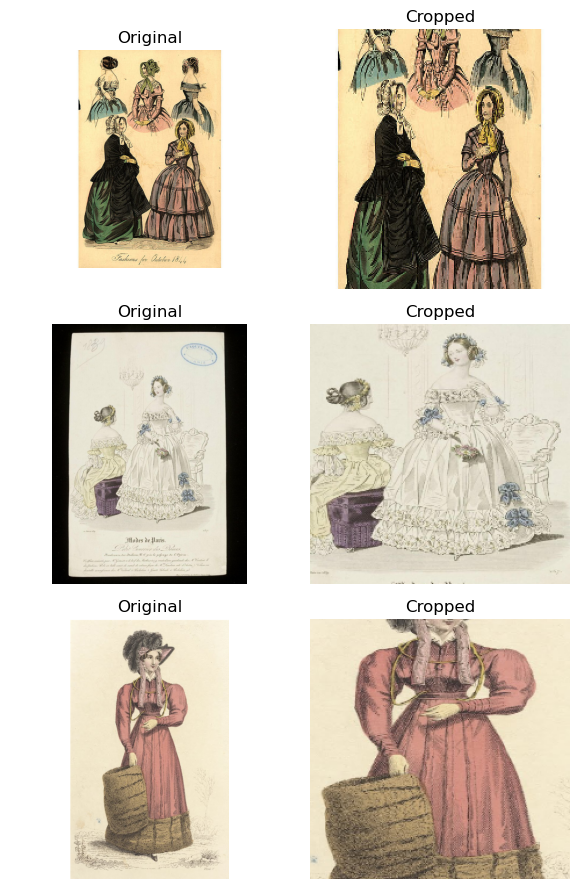

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

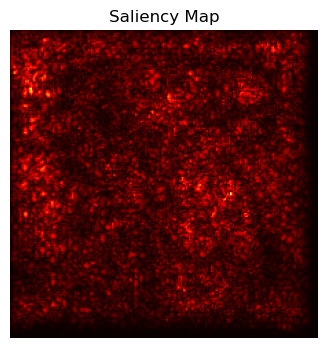

In [ ]:
import matplotlib.pyplot as plt

# Cropped preprocessing (central 65% field of view)
def preprocess_cropped(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_cropped = tf.image.central_crop(img, 0.65)
    img_resized = tf.image.resize(img_cropped, INPUT_SIZE)
    return img, img_resized

# Sample three images from fold 0
fold = 0
df0 = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
df0['file'] = df0['file'].str.replace(r'.*datasets[\\/]', '', regex=True)
sample_paths = [os.path.join(DATA_DIR, p) for p in df0['file'].iloc[:3]]

# 3) Plot original vs cropped
fig, axes = plt.subplots(len(sample_paths), 2, figsize=(6, len(sample_paths)*3))
for i, p in enumerate(sample_paths):
    orig, crop = preprocess_cropped(p)
    axes[i,0].imshow(orig.numpy().astype('uint8'))
    axes[i,0].set_title("Original")
    axes[i,0].axis('off')
    axes[i,1].imshow(crop.numpy().astype('uint8'))
    axes[i,1].set_title("Cropped")
    axes[i,1].axis('off')
plt.tight_layout()
plt.show()

# Build the FULLY-TRAINABLE InceptionV3 base
base = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(*INPUT_SIZE, 3)
)
# (by default base.trainable=True)

# 5) Build your regression model and load fold-0 weights
model = build_model('inceptionv3', base)
model.load_weights('inceptionv3_fold0.h5')

# 6) Compute saliency on the last cropped image
img_norm = crop / 255.0
img_tensor = tf.expand_dims(tf.cast(img_norm, tf.float32), 0)

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    pred = model(img_tensor)
grads = tape.gradient(pred, img_tensor)
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

# 7) Display the saliency map
plt.figure(figsize=(4,4))
plt.imshow(saliency.numpy(), cmap='hot')
plt.title("Saliency Map")
plt.axis('off')
plt.show()


In [9]:
# 1) Cropping + normalization in one preprocess
def preprocess_cropped_reg(path, label, training):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    # central 65%
    img = tf.image.central_crop(img, 0.65)
    img = tf.image.resize(img, INPUT_SIZE)
    if training:
        img = tf.image.random_flip_left_right(img)
    img = img / 255.0
    # normalize label
    label = (label - YEAR_MEAN) / YEAR_STD
    return img, tf.cast(label, tf.float32)

def make_cropped_dataset(df, training):
    df = df.copy()
    df['file'] = df['file'].str.replace(r'.*datasets[\\/]', '', regex=True)
    files  = [os.path.join(DATA_DIR, p) for p in df['file']]
    labels = df['year'].values
    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if training:
        ds = ds.shuffle(len(files))
    ds = ds.map(lambda x,y: preprocess_cropped_reg(x,y,training),
                num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# 2) Prepare folds & run 10-fold CV on InceptionV3
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

results = []

for fold in range(10):
    print(f"\n--- Fold {fold} (cropped images) ---")
    # load CSVs
    val_df = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
    train_df = pd.concat([
        pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
        for i in range(10) if i != fold
    ], ignore_index=True)

    # build datasets
    train_ds = make_cropped_dataset(train_df, training=True)
    val_ds   = make_cropped_dataset(val_df,   training=False)

    # build a fresh InceptionV3 each fold
    base = InceptionV3(weights='imagenet', include_top=False, input_shape=(*INPUT_SIZE,3))
    x   = GlobalAveragePooling2D()(base.output)
    out = Dense(1)(x)
    model = Model(base.input, out)
    model.compile(optimizer=Adam(LR), loss='mse', metrics=['mae'])

    # train
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        f'inceptionv3_cropped_fold{fold}.h5',
        monitor='val_loss', save_best_only=True
    )
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[ckpt],
        verbose=2
    )

    best_mse = min(hist.history['val_loss'])
    results.append(best_mse)
    print(f"→ Best norm-MSE this fold: {best_mse:.4f}")

# 3) Summarize
mean_mse  = np.mean(results)
mean_rmse = np.sqrt(mean_mse)
print(f"\nCropped-InceptionV3 10-fold mean norm-MSE: {mean_mse:.4f}")
print(f"Cropped-InceptionV3 10-fold mean norm-RMSE: {mean_rmse:.4f}")
print(f"≈ {mean_rmse * YEAR_STD:.1f} years off on average")



--- Fold 0 (cropped images) ---
Epoch 1/5
354/354 - 40s - loss: 0.3140 - mae: 0.4219 - val_loss: 0.1766 - val_mae: 0.3056
Epoch 2/5
354/354 - 30s - loss: 0.1303 - mae: 0.2698 - val_loss: 0.1260 - val_mae: 0.2605
Epoch 3/5
354/354 - 30s - loss: 0.0857 - mae: 0.2212 - val_loss: 0.1320 - val_mae: 0.2594
Epoch 4/5
354/354 - 30s - loss: 0.0636 - mae: 0.1904 - val_loss: 0.1175 - val_mae: 0.2532
Epoch 5/5
354/354 - 29s - loss: 0.0467 - mae: 0.1635 - val_loss: 0.1068 - val_mae: 0.2331
→ Best norm-MSE this fold: 0.1068

--- Fold 1 (cropped images) ---
Epoch 1/5
354/354 - 36s - loss: 0.3251 - mae: 0.4304 - val_loss: 0.2274 - val_mae: 0.3577
Epoch 2/5
354/354 - 30s - loss: 0.1341 - mae: 0.2756 - val_loss: 0.1320 - val_mae: 0.2647
Epoch 3/5
354/354 - 29s - loss: 0.0837 - mae: 0.2177 - val_loss: 0.1178 - val_mae: 0.2498
Epoch 4/5
354/354 - 29s - loss: 0.0687 - mae: 0.1965 - val_loss: 0.1165 - val_mae: 0.2385
Epoch 5/5
354/354 - 30s - loss: 0.0538 - mae: 0.1725 - val_loss: 0.1035 - val_mae: 0.2228


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1034 (Conv2D)            (None, 111, 111, 32) 864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1034 (Batch (None, 111, 111, 32) 96          conv2d_1034[0][0]                
__________________________________________________________________________________________________
activation_1034 (Activation)    (None, 111, 111, 32) 0           batch_normalization_1034[0][0]   
___________________________________________________________________________________________

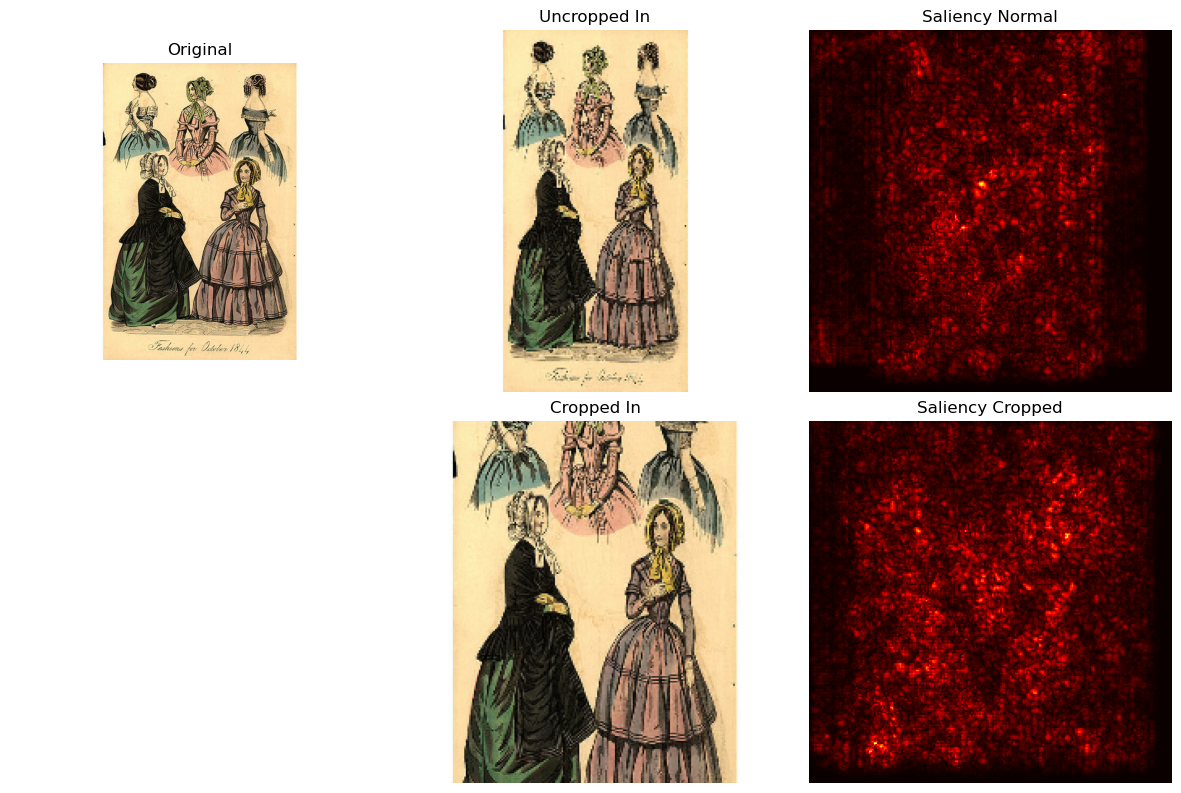

: 

In [ ]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Helpers to preprocess
def preprocess_uncropped(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_resized = tf.image.resize(img, INPUT_SIZE)
    img_norm = img_resized / 255.0
    return img, img_norm

def preprocess_cropped(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img_crop = tf.image.central_crop(img, 0.65)
    img_resized = tf.image.resize(img_crop, INPUT_SIZE)
    img_norm = img_resized / 255.0
    return img, img_norm

# 1) Grab one example from fold0
fold = 0
df0 = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
df0['file'] = df0['file'].str.replace(r'.*datasets[\\/]', '', regex=True)
sample_path = os.path.join(DATA_DIR, df0['file'].iloc[0])

# 2) Preprocess both ways
orig, uncrop_input = preprocess_uncropped(sample_path)
_,    crop_input   = preprocess_cropped(sample_path)

# 3) Build & load the NORMAL InceptionV3 model
base1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(*INPUT_SIZE,3))
model_norm = build_model('inceptionv3', base1)
model_norm.load_weights('inceptionv3_fold0.h5')

# 4) Build & load the CROPPED-InceptionV3 model
base2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(*INPUT_SIZE,3))
model_crop = build_model('inceptionv3', base2)
model_crop.load_weights('inceptionv3_cropped_fold0.h5')

# 5) Saliency function
def get_saliency(model, inp):
    inp = tf.expand_dims(inp, 0)
    with tf.GradientTape() as tape:
        tape.watch(inp)
        pred = model(inp)
    grads = tape.gradient(pred, inp)
    return tf.reduce_max(tf.abs(grads), axis=-1)[0].numpy()

sal_norm = get_saliency(model_norm, uncrop_input)
sal_crop = get_saliency(model_crop, crop_input)

# 6) Plot everything
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes[0,0].imshow(orig.numpy().astype('uint8'))
axes[0,0].set_title("Original");     axes[0,0].axis('off')
axes[0,1].imshow(uncrop_input.numpy())
axes[0,1].set_title("Uncropped In"); axes[0,1].axis('off')
axes[0,2].imshow(sal_norm, cmap='hot')
axes[0,2].set_title("Saliency Normal"); axes[0,2].axis('off')

axes[1,0].axis('off')  # blank
axes[1,1].imshow(crop_input.numpy())
axes[1,1].set_title("Cropped In");   axes[1,1].axis('off')
axes[1,2].imshow(sal_crop, cmap='hot')
axes[1,2].set_title("Saliency Cropped"); axes[1,2].axis('off')

plt.tight_layout()
plt.show()


In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model_name = 'vgg16'
results_vgg = []

for fold in range(10):
    print(f'\n=== {model_name} | Fold {fold} ===')
    val_df = pd.read_csv(os.path.join(DATA_DIR, f'fold{fold}.csv'))
    train_df = pd.concat([
        pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
        for i in range(10) if i != fold
    ], ignore_index=True)

    # 2) strip off everything through "datasets/"
    for df in (train_df, val_df):
        df['file'] = df['file'].str.replace(
            r'.*datasets[\\/]', '', regex=True
        )

    train_ds = make_dataset(train_df, training=True)
    val_ds   = make_dataset(val_df,   training=False)

    base = VGG16(
      weights='imagenet',
      include_top=False,
      input_shape=(*INPUT_SIZE, 3)
    )

    model = build_model(model_name, base)

    ckpt = tf.keras.callbacks.ModelCheckpoint(
        f'{model_name}_fold{fold}.h5',
        monitor='val_loss', save_best_only=True
    )
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=[ckpt],
        verbose=2
    )

    best = min(hist.history['val_loss'])
    results_vgg.append(best)
    print(f'→ best normalized-MSE: {best:.4f}')

mean_mse  = np.mean(results_vgg)
mean_rmse = np.sqrt(mean_mse)
print(f'\nVGG16 10-fold mean norm-MSE: {mean_mse:.4f}')
print(f'VGG16 10-fold mean norm-RMSE: {mean_rmse:.4f}')
print(f'≈ {mean_rmse * YEAR_STD:.1f} years off on average')



=== vgg16 | Fold 0 ===
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

In [6]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet101, NASNetMobile, InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ── Block 1: build_model ──
def build_model(base, lr=LR):
    x   = GlobalAveragePooling2D()(base.output)
    out = Dense(1)(x)   # regression head
    model = Model(base.input, out)
    #model.summary()
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ── Block 2: use_model ──
def use_model(base, model_name):
    best_results = {'training': None, 'validation': None, 'test': None}
    TEST_FOLD = 9
    test_df   = pd.read_csv(os.path.join(DATA_DIR, f'fold{TEST_FOLD}.csv'))

    for val_fold in range(9):
        print(f'\n  → inner CV: fold {val_fold}')
        # load train/val
        val_df = pd.read_csv(os.path.join(DATA_DIR, f'fold{val_fold}.csv'))
        train_df = pd.concat([
            pd.read_csv(os.path.join(DATA_DIR, f'fold{i}.csv'))
            for i in range(9) if i != val_fold
        ], ignore_index=True)

        # strip leading 'datasets/'
        for df in (train_df, val_df, test_df):
            df['file'] = df['file'].str.replace(r'.*datasets[\\/]', '', regex=True)

        train_ds = make_dataset(train_df, training=True)
        val_ds   = make_dataset(val_df,   training=False)
        test_ds  = make_dataset(test_df,  training=False)

        # build & fit
        model = build_model(base, lr=LR)
        ckpt  = tf.keras.callbacks.ModelCheckpoint(
            f'{model_name}_fold{val_fold}.h5',
            monitor='val_loss', save_best_only=True
        )
        hist = model.fit(
            train_ds, validation_data=val_ds,
            epochs=EPOCHS, callbacks=[ckpt], verbose=2
        )

        tr_losses = hist.history['loss']
        vl_losses = hist.history['val_loss']

        best_tr = min(tr_losses)
        best_vl = min(vl_losses)

        # first-time init or better?
        if best_results['training'] is None or best_tr < best_results['training']:
            best_results['training'] = best_tr
        if best_results['validation'] is None or best_vl < best_results['validation']:
            best_results['validation'] = best_vl

        print(f'    best train MSE: {best_tr:.4f}, best val MSE: {best_vl:.4f}')

    # final test eval on fold 9
    test_eval = model.evaluate(test_ds, verbose=0)
    best_results['test'] = test_eval

    return best_results['training'], best_results['validation'], best_results['test']

# ── Block 3: outer loop over models ──
models = ['resnet101','nasnetmobile','inceptionv3']
results = {m: [] for m in models}

for model_name in models:
    print(f'\n===== {model_name} =====')
    # pick the right base
    if model_name == 'resnet101':
        base = ResNet101(weights='imagenet', include_top=False,
                         input_shape=(*INPUT_SIZE,3))
    elif model_name == 'nasnetmobile':
        base = NASNetMobile(weights='imagenet', include_top=False,
                            input_shape=(*INPUT_SIZE,3))
    elif model_name == 'inceptionv3':
        base = InceptionV3(weights='imagenet', include_top=False,
                           input_shape=(*INPUT_SIZE,3))
    else:
        raise ValueError(model_name)

    # run inner CV + test
    best_tr, best_val, best_test = use_model(base, model_name)
    print(f'→ {model_name} best train MSE: {best_tr:.4f}')
    print(f'→ {model_name} best val   MSE: {best_val:.4f}')
    print(f'→ {model_name} test eval : {best_test}')

    results[model_name].append(best_test)

# final summary
print('\n=== Final test MSE per model ===')
for m, vals in results.items():
    print(f' {m}: {[f"{v:.4f}" for v in vals]}')

pd.DataFrame(results).to_csv('cv_results.csv', index=False)



===== resnet101 =====

  → inner CV: fold 0
Epoch 1/5
314/314 - 61s - loss: 0.3064 - mae: 0.4176 - val_loss: 1.1547 - val_mae: 0.9205


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 45s - loss: 0.1076 - mae: 0.2489 - val_loss: 0.6954 - val_mae: 0.6592
Epoch 3/5
314/314 - 45s - loss: 0.0664 - mae: 0.1953 - val_loss: 0.3051 - val_mae: 0.4196
Epoch 4/5
314/314 - 45s - loss: 0.0472 - mae: 0.1649 - val_loss: 0.0921 - val_mae: 0.2194
Epoch 5/5
314/314 - 45s - loss: 0.0345 - mae: 0.1398 - val_loss: 0.0800 - val_mae: 0.1916
    best train MSE: 0.0345, best val MSE: 0.0800

  → inner CV: fold 1
Epoch 1/5
314/314 - 55s - loss: 0.1061 - mae: 0.2433 - val_loss: 0.1077 - val_mae: 0.2521


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 45s - loss: 0.0538 - mae: 0.1706 - val_loss: 0.0643 - val_mae: 0.1787
Epoch 3/5
314/314 - 45s - loss: 0.0410 - mae: 0.1478 - val_loss: 0.1146 - val_mae: 0.2315
Epoch 4/5
314/314 - 45s - loss: 0.0290 - mae: 0.1248 - val_loss: 0.0597 - val_mae: 0.1689
Epoch 5/5
314/314 - 45s - loss: 0.0280 - mae: 0.1201 - val_loss: 0.0827 - val_mae: 0.1960
    best train MSE: 0.0280, best val MSE: 0.0597

  → inner CV: fold 2
Epoch 1/5
314/314 - 56s - loss: 0.0677 - mae: 0.1797 - val_loss: 0.0961 - val_mae: 0.2469


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 46s - loss: 0.0291 - mae: 0.1268 - val_loss: 0.0418 - val_mae: 0.1607
Epoch 3/5
314/314 - 46s - loss: 0.0241 - mae: 0.1110 - val_loss: 0.0952 - val_mae: 0.2243
Epoch 4/5
314/314 - 46s - loss: 0.0304 - mae: 0.1261 - val_loss: 0.0396 - val_mae: 0.1485
Epoch 5/5
314/314 - 46s - loss: 0.0183 - mae: 0.0982 - val_loss: 0.0329 - val_mae: 0.1325
    best train MSE: 0.0183, best val MSE: 0.0329

  → inner CV: fold 3
Epoch 1/5
314/314 - 57s - loss: 0.0540 - mae: 0.1491 - val_loss: 0.0203 - val_mae: 0.1073


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 46s - loss: 0.0268 - mae: 0.1178 - val_loss: 0.0460 - val_mae: 0.1674
Epoch 3/5
314/314 - 46s - loss: 0.0213 - mae: 0.1040 - val_loss: 0.0449 - val_mae: 0.1510
Epoch 4/5
314/314 - 46s - loss: 0.0231 - mae: 0.1065 - val_loss: 0.0267 - val_mae: 0.1166
Epoch 5/5
314/314 - 46s - loss: 0.0141 - mae: 0.0853 - val_loss: 0.0204 - val_mae: 0.0993
    best train MSE: 0.0141, best val MSE: 0.0203

  → inner CV: fold 4
Epoch 1/5
314/314 - 56s - loss: 0.0334 - mae: 0.1209 - val_loss: 0.0237 - val_mae: 0.1226


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 45s - loss: 0.0154 - mae: 0.0888 - val_loss: 0.0128 - val_mae: 0.0791
Epoch 3/5
314/314 - 45s - loss: 0.0103 - mae: 0.0716 - val_loss: 0.0226 - val_mae: 0.1235
Epoch 4/5
314/314 - 45s - loss: 0.0097 - mae: 0.0678 - val_loss: 0.0169 - val_mae: 0.0908
Epoch 5/5
314/314 - 45s - loss: 0.0445 - mae: 0.1428 - val_loss: 0.0574 - val_mae: 0.1844
    best train MSE: 0.0097, best val MSE: 0.0128

  → inner CV: fold 5
Epoch 1/5
314/314 - 55s - loss: 0.0549 - mae: 0.1439 - val_loss: 0.0175 - val_mae: 0.0933


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 45s - loss: 0.0158 - mae: 0.0891 - val_loss: 0.0651 - val_mae: 0.1429
Epoch 3/5
314/314 - 45s - loss: 0.0121 - mae: 0.0786 - val_loss: 0.0198 - val_mae: 0.1040
Epoch 4/5
314/314 - 45s - loss: 0.0129 - mae: 0.0781 - val_loss: 0.0372 - val_mae: 0.1396
Epoch 5/5
314/314 - 45s - loss: 0.0236 - mae: 0.1040 - val_loss: 0.0264 - val_mae: 0.1094
    best train MSE: 0.0121, best val MSE: 0.0175

  → inner CV: fold 6
Epoch 1/5
314/314 - 55s - loss: 0.0390 - mae: 0.1185 - val_loss: 0.0135 - val_mae: 0.0832


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 45s - loss: 0.0107 - mae: 0.0727 - val_loss: 0.0118 - val_mae: 0.0748
Epoch 3/5
314/314 - 45s - loss: 0.0169 - mae: 0.0858 - val_loss: 0.1284 - val_mae: 0.2099
Epoch 4/5
314/314 - 45s - loss: 0.0204 - mae: 0.0971 - val_loss: 0.0307 - val_mae: 0.1166
Epoch 5/5
314/314 - 45s - loss: 0.0129 - mae: 0.0791 - val_loss: 0.0179 - val_mae: 0.0911
    best train MSE: 0.0107, best val MSE: 0.0118

  → inner CV: fold 7
Epoch 1/5
314/314 - 56s - loss: 0.0530 - mae: 0.1232 - val_loss: 0.0100 - val_mae: 0.0738


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 45s - loss: 0.0112 - mae: 0.0714 - val_loss: 0.0299 - val_mae: 0.1264
Epoch 3/5
314/314 - 45s - loss: 0.0106 - mae: 0.0712 - val_loss: 0.0143 - val_mae: 0.0786
Epoch 4/5
314/314 - 45s - loss: 0.0080 - mae: 0.0598 - val_loss: 0.0086 - val_mae: 0.0573
Epoch 5/5
314/314 - 45s - loss: 0.0064 - mae: 0.0548 - val_loss: 0.0084 - val_mae: 0.0606
    best train MSE: 0.0064, best val MSE: 0.0084

  → inner CV: fold 8
Epoch 1/5
314/314 - 55s - loss: 0.0460 - mae: 0.1106 - val_loss: 0.0097 - val_mae: 0.0691


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 45s - loss: 0.0076 - mae: 0.0605 - val_loss: 0.0089 - val_mae: 0.0737
Epoch 3/5
314/314 - 45s - loss: 0.0123 - mae: 0.0709 - val_loss: 0.0235 - val_mae: 0.1186
Epoch 4/5
314/314 - 45s - loss: 0.0080 - mae: 0.0618 - val_loss: 0.0075 - val_mae: 0.0553
Epoch 5/5
314/314 - 45s - loss: 0.0071 - mae: 0.0566 - val_loss: 0.0299 - val_mae: 0.1202
    best train MSE: 0.0071, best val MSE: 0.0075
→ resnet101 best train MSE: 0.0064
→ resnet101 best val   MSE: 0.0075
→ resnet101 test eval : [0.07129234820604324, 0.16703492403030396]

===== nasnetmobile =====

  → inner CV: fold 0
Epoch 1/5
314/314 - 59s - loss: 0.2850 - mae: 0.3894 - val_loss: 0.3904 - val_mae: 0.4881


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 36s - loss: 0.1139 - mae: 0.2479 - val_loss: 0.4657 - val_mae: 0.5402
Epoch 3/5
314/314 - 36s - loss: 0.0762 - mae: 0.2020 - val_loss: 0.2885 - val_mae: 0.4068
Epoch 4/5
314/314 - 36s - loss: 0.0539 - mae: 0.1707 - val_loss: 0.2709 - val_mae: 0.3909
Epoch 5/5
314/314 - 36s - loss: 0.0413 - mae: 0.1525 - val_loss: 0.2475 - val_mae: 0.3741
    best train MSE: 0.0413, best val MSE: 0.2475

  → inner CV: fold 1
Epoch 1/5
314/314 - 58s - loss: 0.0838 - mae: 0.2107 - val_loss: 0.2404 - val_mae: 0.3850


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 36s - loss: 0.0459 - mae: 0.1564 - val_loss: 0.2361 - val_mae: 0.3865
Epoch 3/5
314/314 - 36s - loss: 0.0332 - mae: 0.1338 - val_loss: 0.2373 - val_mae: 0.3920
Epoch 4/5
314/314 - 36s - loss: 0.0254 - mae: 0.1170 - val_loss: 0.2667 - val_mae: 0.4177
Epoch 5/5
314/314 - 36s - loss: 0.0235 - mae: 0.1136 - val_loss: 0.2455 - val_mae: 0.3990
    best train MSE: 0.0235, best val MSE: 0.2361

  → inner CV: fold 2
Epoch 1/5
314/314 - 58s - loss: 0.0579 - mae: 0.1669 - val_loss: 0.2644 - val_mae: 0.4080


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 36s - loss: 0.0258 - mae: 0.1161 - val_loss: 0.1739 - val_mae: 0.3460
Epoch 3/5
314/314 - 36s - loss: 0.0203 - mae: 0.1041 - val_loss: 0.0952 - val_mae: 0.2402
Epoch 4/5
314/314 - 36s - loss: 0.0170 - mae: 0.0946 - val_loss: 0.1095 - val_mae: 0.2693
Epoch 5/5
314/314 - 36s - loss: 0.0137 - mae: 0.0847 - val_loss: 0.1010 - val_mae: 0.2586
    best train MSE: 0.0137, best val MSE: 0.0952

  → inner CV: fold 3
Epoch 1/5
314/314 - 60s - loss: 0.0489 - mae: 0.1422 - val_loss: 0.3549 - val_mae: 0.5408


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 37s - loss: 0.0165 - mae: 0.0918 - val_loss: 0.3656 - val_mae: 0.5598
Epoch 3/5
314/314 - 37s - loss: 0.0121 - mae: 0.0790 - val_loss: 0.2458 - val_mae: 0.4610
Epoch 4/5
314/314 - 37s - loss: 0.0113 - mae: 0.0740 - val_loss: 0.3011 - val_mae: 0.5035
Epoch 5/5
314/314 - 37s - loss: 0.0099 - mae: 0.0704 - val_loss: 0.2295 - val_mae: 0.4469
    best train MSE: 0.0099, best val MSE: 0.2295

  → inner CV: fold 4
Epoch 1/5
314/314 - 60s - loss: 0.0321 - mae: 0.1139 - val_loss: 0.1144 - val_mae: 0.2643


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 38s - loss: 0.0116 - mae: 0.0760 - val_loss: 0.1058 - val_mae: 0.2588
Epoch 3/5
314/314 - 37s - loss: 0.0109 - mae: 0.0718 - val_loss: 0.0602 - val_mae: 0.1910
Epoch 4/5
314/314 - 38s - loss: 0.0091 - mae: 0.0660 - val_loss: 0.0539 - val_mae: 0.1770
Epoch 5/5
314/314 - 38s - loss: 0.0092 - mae: 0.0639 - val_loss: 0.0595 - val_mae: 0.1921
    best train MSE: 0.0091, best val MSE: 0.0539

  → inner CV: fold 5
Epoch 1/5
314/314 - 59s - loss: 0.0516 - mae: 0.1248 - val_loss: 0.4010 - val_mae: 0.5537


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 37s - loss: 0.0093 - mae: 0.0678 - val_loss: 0.2811 - val_mae: 0.4541
Epoch 3/5
314/314 - 37s - loss: 0.0084 - mae: 0.0612 - val_loss: 0.1935 - val_mae: 0.3715
Epoch 4/5
314/314 - 36s - loss: 0.0064 - mae: 0.0543 - val_loss: 0.1577 - val_mae: 0.3375
Epoch 5/5
314/314 - 36s - loss: 0.0059 - mae: 0.0518 - val_loss: 0.1223 - val_mae: 0.3019
    best train MSE: 0.0059, best val MSE: 0.1223

  → inner CV: fold 6
Epoch 1/5
314/314 - 60s - loss: 0.0266 - mae: 0.0948 - val_loss: 0.1804 - val_mae: 0.3308


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 38s - loss: 0.0067 - mae: 0.0556 - val_loss: 0.1276 - val_mae: 0.2816
Epoch 3/5
314/314 - 38s - loss: 0.0188 - mae: 0.0774 - val_loss: 0.1011 - val_mae: 0.2553
Epoch 4/5
314/314 - 38s - loss: 0.0109 - mae: 0.0668 - val_loss: 0.1115 - val_mae: 0.2605
Epoch 5/5
314/314 - 38s - loss: 0.0062 - mae: 0.0518 - val_loss: 0.0734 - val_mae: 0.2118
    best train MSE: 0.0062, best val MSE: 0.0734

  → inner CV: fold 7
Epoch 1/5
314/314 - 60s - loss: 0.0211 - mae: 0.0848 - val_loss: 0.2000 - val_mae: 0.3451


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 38s - loss: 0.0091 - mae: 0.0619 - val_loss: 0.0729 - val_mae: 0.2216
Epoch 3/5
314/314 - 38s - loss: 0.0091 - mae: 0.0572 - val_loss: 0.0884 - val_mae: 0.2278
Epoch 4/5
314/314 - 37s - loss: 0.0101 - mae: 0.0588 - val_loss: 0.0739 - val_mae: 0.1983
Epoch 5/5
314/314 - 38s - loss: 0.0084 - mae: 0.0549 - val_loss: 0.0589 - val_mae: 0.1804
    best train MSE: 0.0084, best val MSE: 0.0589

  → inner CV: fold 8
Epoch 1/5
314/314 - 59s - loss: 0.0621 - mae: 0.1249 - val_loss: 0.4398 - val_mae: 0.4965


c:\Users\maxim\anaconda3\envs\deep_learning_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
314/314 - 36s - loss: 0.0100 - mae: 0.0631 - val_loss: 0.3013 - val_mae: 0.4221
Epoch 3/5
314/314 - 37s - loss: 0.0075 - mae: 0.0560 - val_loss: 0.2400 - val_mae: 0.3782
Epoch 4/5
314/314 - 36s - loss: 0.0051 - mae: 0.0463 - val_loss: 0.1797 - val_mae: 0.3181
Epoch 5/5
314/314 - 36s - loss: 0.0042 - mae: 0.0418 - val_loss: 0.1527 - val_mae: 0.2942
    best train MSE: 0.0042, best val MSE: 0.1527
→ nasnetmobile best train MSE: 0.0042
→ nasnetmobile best val   MSE: 0.0539
→ nasnetmobile test eval : [0.23110969364643097, 0.34434372186660767]

===== inceptionv3 =====

  → inner CV: fold 0
Epoch 1/5
314/314 - 37s - loss: 0.3012 - mae: 0.4117 - val_loss: 0.1773 - val_mae: 0.3198
Epoch 2/5
314/314 - 25s - loss: 0.1215 - mae: 0.2621 - val_loss: 0.1139 - val_mae: 0.2459
Epoch 3/5
314/314 - 26s - loss: 0.0855 - mae: 0.2212 - val_loss: 0.0947 - val_mae: 0.2170
Epoch 4/5
314/314 - 25s - loss: 0.0596 - mae: 0.1843 - val_loss: 0.0892 - val_mae: 0.2079
Epoch 5/5
314/314 - 25s - loss: 0.0448

TypeError: unsupported format string passed to list.__format__